In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

# 1. Pre-Processing

In [ ]:
df=pd.read_csv('sector51aqi.csv',index_col=[0], parse_dates=['Date'])
df

,Date,AQI
0,2020-03-05,73.0
1,2020-03-06,55.0
2,2020-03-07,78.0
3,2020-03-08,120.0
4,2020-03-09,179.0
...,...,...
1608,2024-07-30,108.0
1609,2024-07-31,124.0
1610,2024-08-01,77.0
1611,2024-08-02,112.0


<Axes: xlabel='Date'>

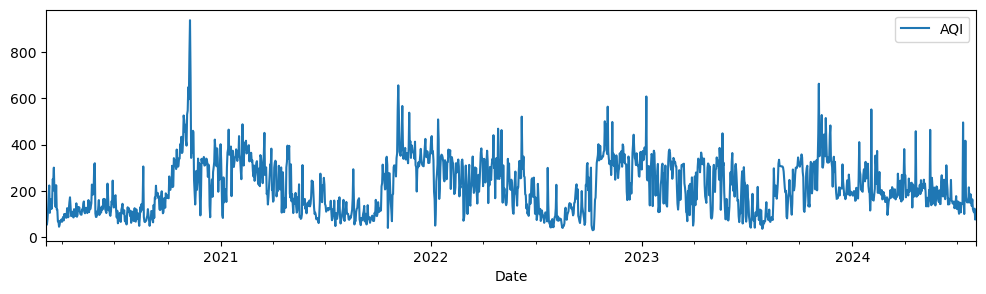

In [ ]:
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index(df.Date)
df.drop('Date', axis = 1, inplace = True)
df.plot(figsize=(12,3))

In this step, Date is set as the index, and the original Date column is deleted.

In [ ]:
df=df.resample("ME").mean()

The data was resampled using a monthly frequency (ME - Month End), so the average AQI was calculated for each month end.This reduces the granularity of the data for seasonal trend analysis.

<Axes: xlabel='Date'>

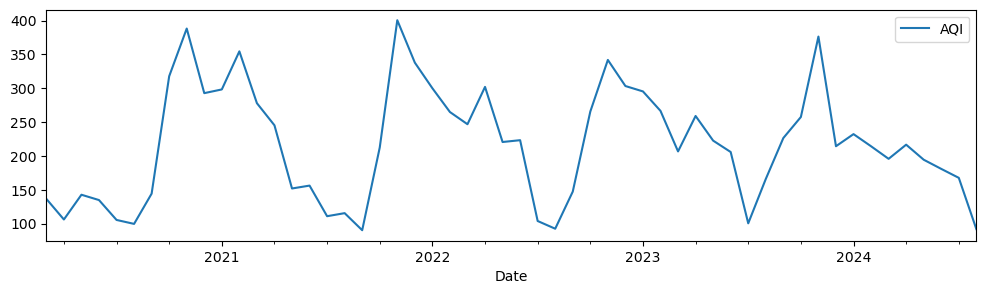

In [ ]:
df.plot(figsize=(12,3))

## Naive forecasting
## one-shif

In [ ]:
pred=df.copy()
pred=pred.shift()

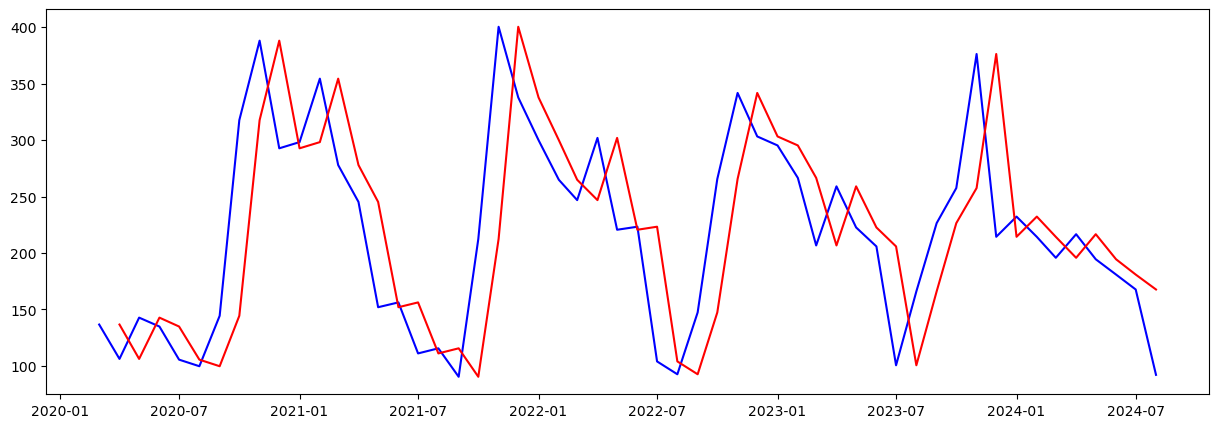

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df,"b-")
plt.plot(pred,"r-")

Naive predictions are made using data that is shifted one period forward. This technique is useful as a baseline to compare the performance of more complex prediction models.

# dekomposisi additive

In [ ]:
from jcopml.time_series.decomposition import additive_decomposition

In [ ]:
series=df.AQI

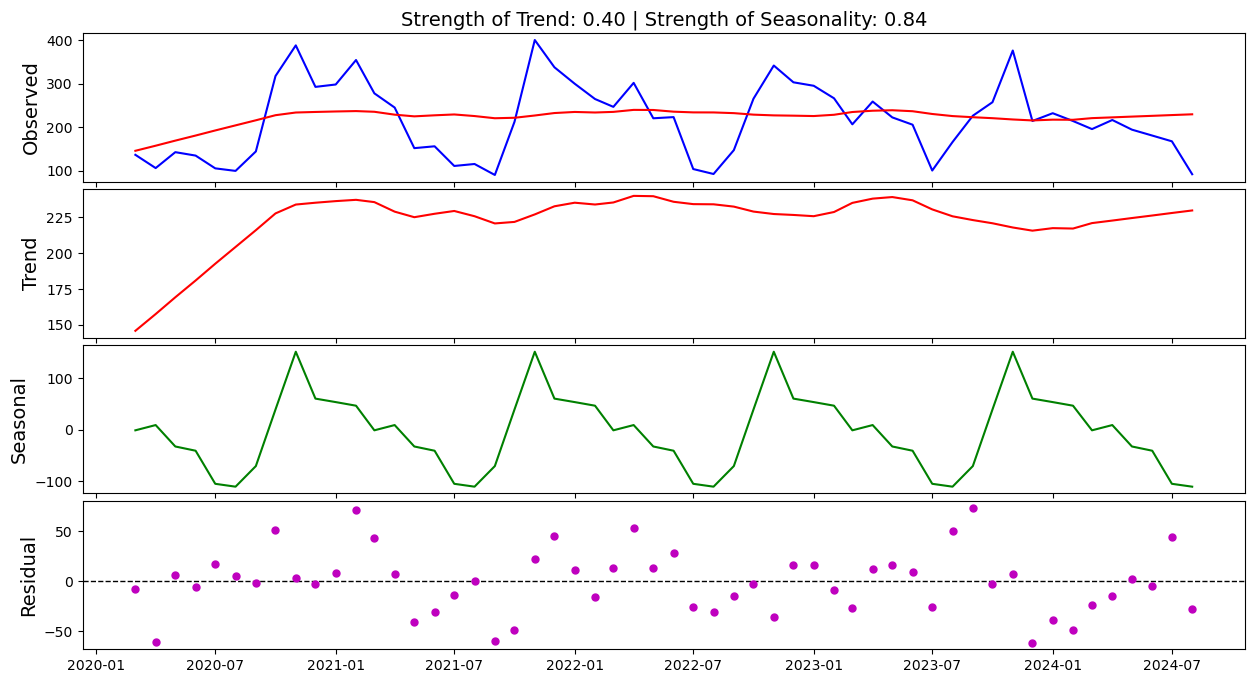

In [ ]:
components=additive_decomposition(series, plot=True)

Additive and multiplicative decomposition is performed to separate the time series into trend, seasonal and residual components. Additive is used when the seasonal variation is constant over time, while multiplicative is used when the seasonal variation changes over time.

# multiplicative decomposition

In [ ]:
from jcopml.time_series.decomposition import multiplicative_decomposition

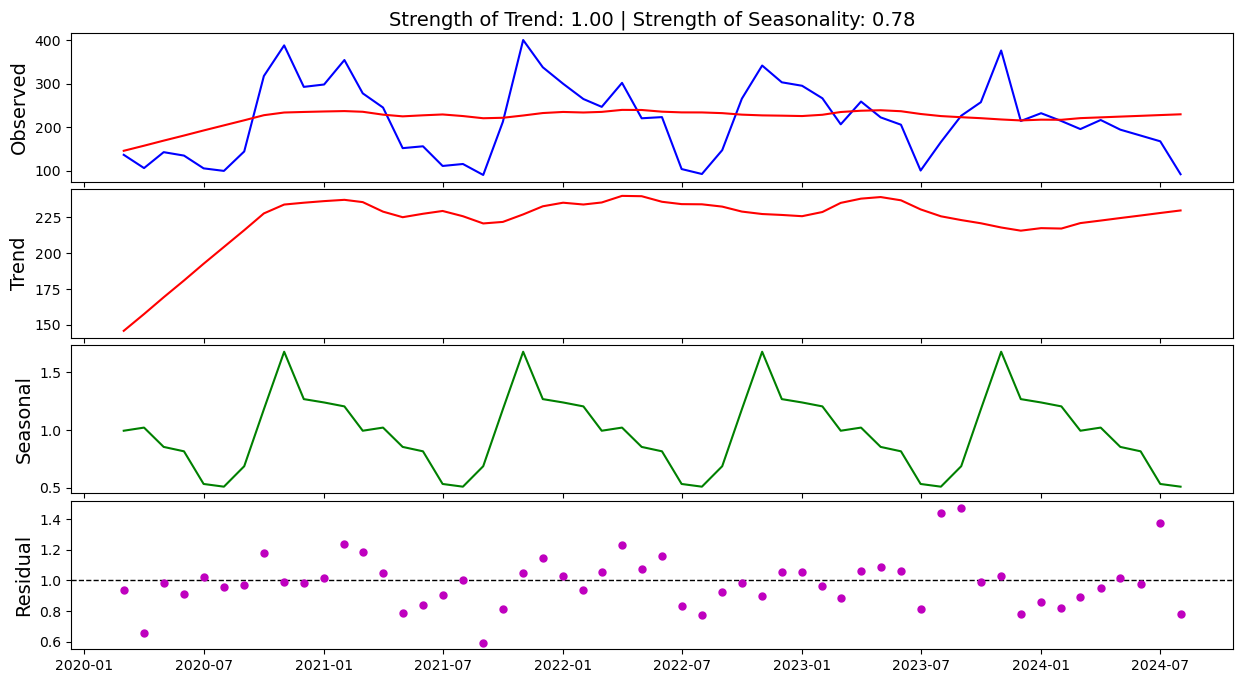

In [ ]:
mseries=df.AQI
mcomponents=multiplicative_decomposition(series, plot=True)

# Seasonal Trend decomposition with LOESS (STL)

In [ ]:
from jcopml.time_series.decomposition import stl_decomposition

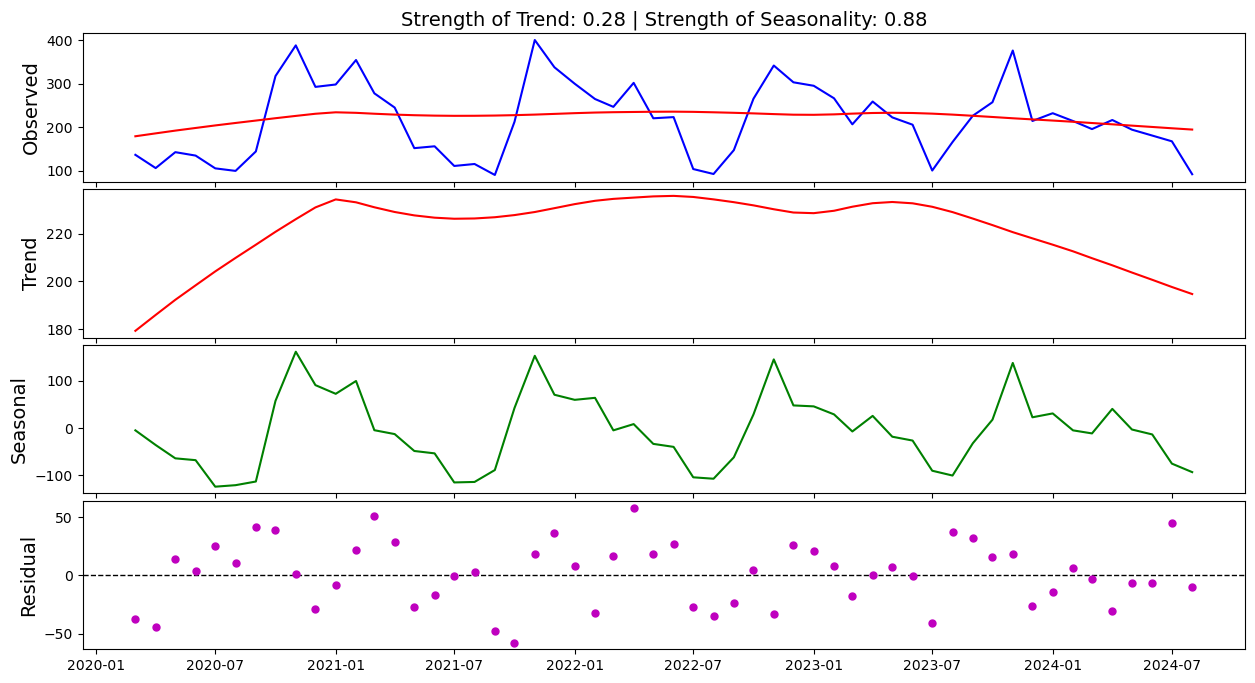

In [ ]:
STLcomponents = stl_decomposition(series,plot=True)

STL (Seasonal-Trend decomposition using LOESS) is used for more flexible time series decomposition, which can handle more complex seasonal patterns.

# Error Trend Seasonal (ETS)

<Axes: xlabel='Date'>

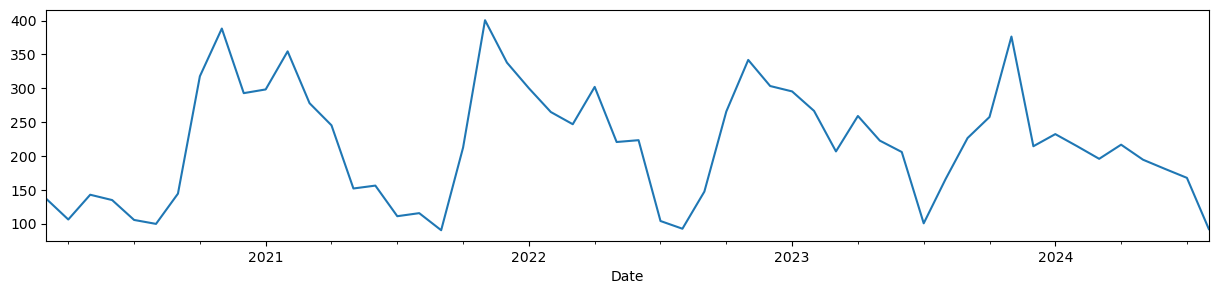

In [ ]:
X_train, X_test=series[:-25], series[-25:]
series.plot(figsize=(15,3))

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
es=ExponentialSmoothing(X_train, seasonal="add", seasonal_periods=12, use_boxcox=True)
#jika ada trend
#es=ExponentialSmoothing(X_train,trend="add"/mul" seasonal="add/mul", seasonal_periods=12, use_boxcox=True)
model=es.fit(optimized=True)

ETS (Error-Trend-Seasonal) is used to capture trends and seasonality in the data. seasonal=“add” indicates that the seasonal component is added additively, and seasonal_periods=12 means that the seasonal pattern repeats every 12 periods (for example, one year in monthly data).

# Forecast

In [ ]:
fpred=model.predict(len(X_train)+5, len(X_train)+34)

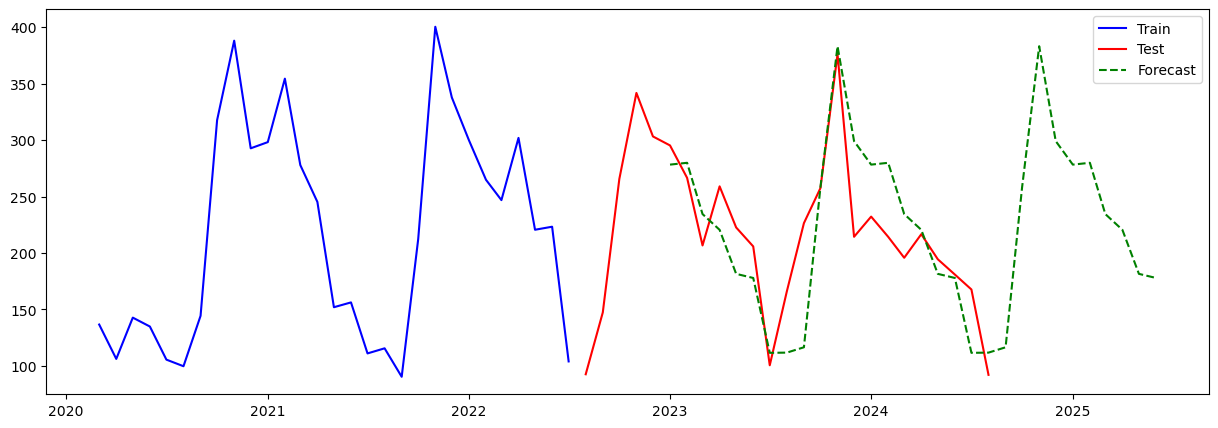

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(X_train,"b-", label='Train')
plt.plot(X_test,"r-", label='Test')
plt.plot(fpred,"g--", label='Forecast')
plt.legend()

The predictions generated by the model appear to follow a similar pattern to the test data. The model managed to capture some of the seasonal patterns and trends, although there were some inaccuracies especially around the peak AQI values in 2024. The forward predictions show a decline in AQI after the peak in early 2024, which is consistent with previous seasonal patterns.

# uji stationarity menggunakan ADF dan KPSS
## ADF=Augmented Dick Fuller Test
## KPSS=Kwiatkowski Phillips Schmidit Shint Test

ADF (Augmented Dickey-Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin) are used to test the stationarity of time series. ADF tests the null hypothesis that the series is non-stationary, while KPSS tests the null hypothesis that the series has a stationary trend.

In [ ]:
from jcopml.time_series import stationarity_tester

<Axes: xlabel='Date'>

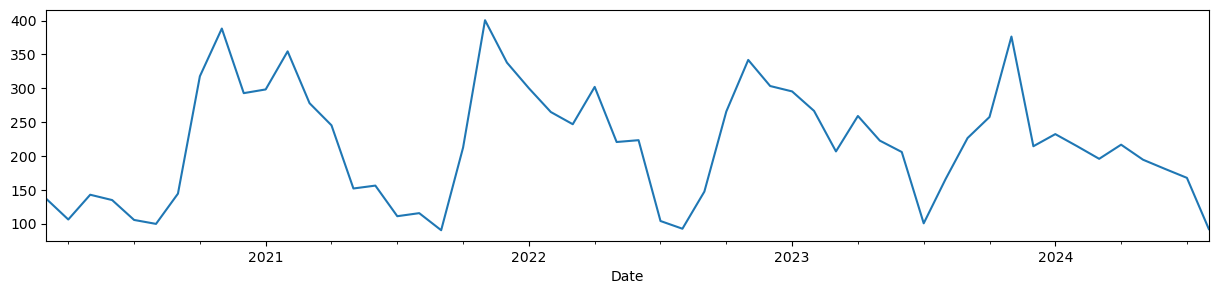

In [ ]:
series=df.AQI
X_train,X_test=series[:-25],series[-25:]
series.plot(figsize=(15,3))

In [ ]:
stationarity_tester(series)

ADF:        Series is non-stationary
KPSS:       Series is trend stationary
Conclusion: Series is trend stationary. Try detrending the series.


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-1.200885,0.673215,-3.596636,-2.933297,-2.604991,False
KPSS,0.072756,0.1,0.739,0.463,0.347,False


<Axes: xlabel='Date'>

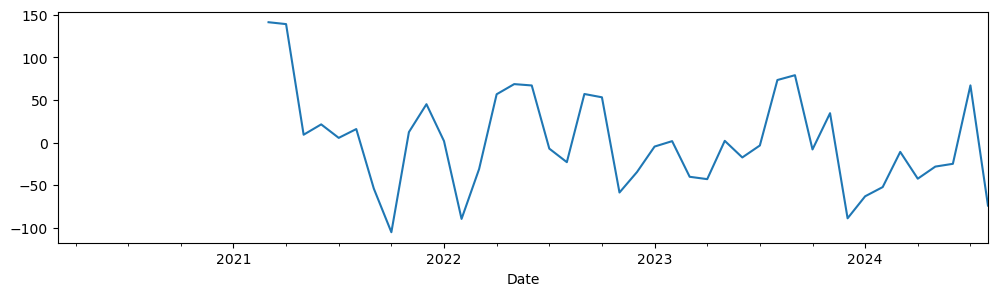

In [ ]:
series.diff(12).plot(figsize=(12,3))

If the series is not stationary, de-trending is done by differencing (subtracting the value from the previous lag).In this case, differencing at lag 12 is performed to remove the seasonal trend.

In [ ]:
stationarity_tester(series.diff(12))

ADF:        Series is stationary
KPSS:       Series is trend stationary
Conclusion: Series is stationary


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-4.670258,0.000096,-3.600983,-2.935135,-2.605963,True
KPSS,0.290863,0.1,0.739,0.463,0.347,False


In [ ]:
components= stl_decomposition(series)

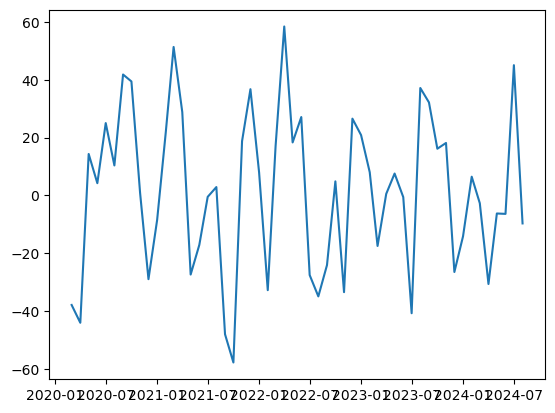

In [ ]:
plt.plot(components.resid)

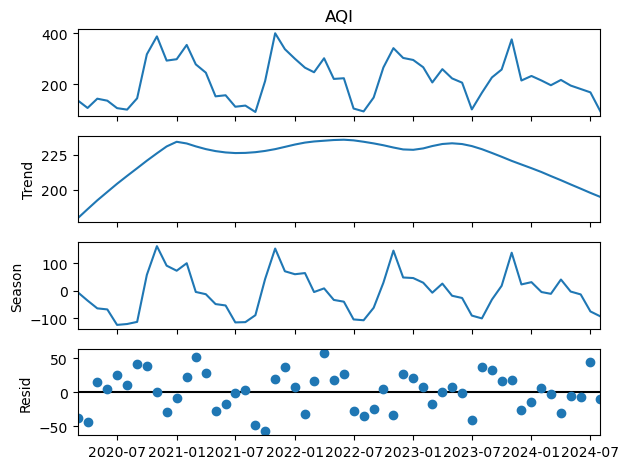

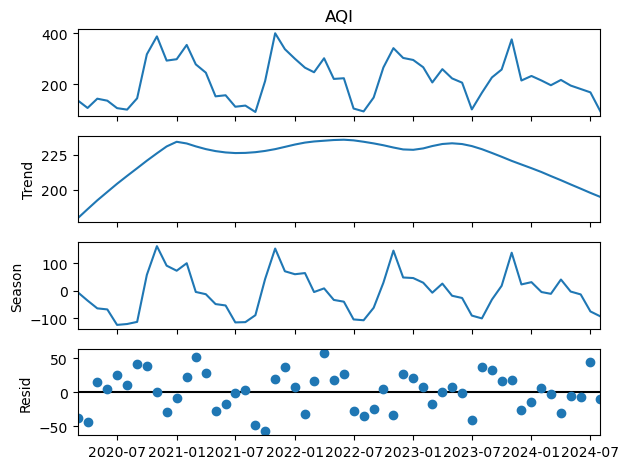

In [ ]:
components.plot()

# Recomended way -> Model search menggunalan AIC,AICc,BIC
### AIC= Akaike Information Criterion
### AICc= Corrected AIC
### BIC= Bayesian Information Criterion

# AUTO ARIMA

In [ ]:
from pmdarima import auto_arima

<Axes: xlabel='Date'>

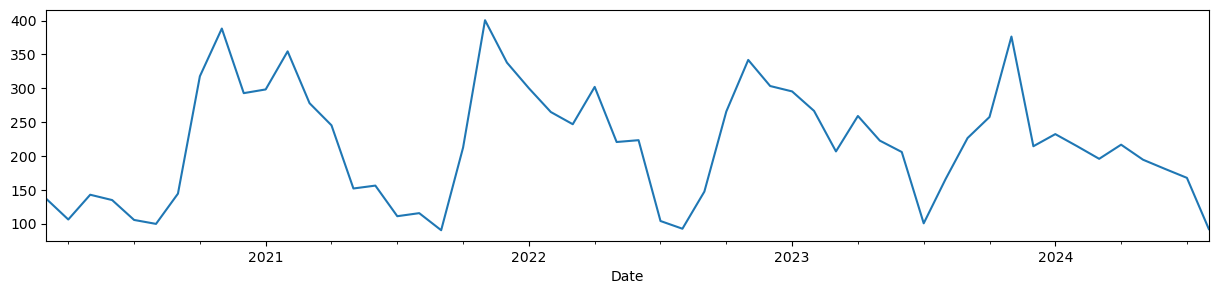

In [ ]:
series=df.AQI
X_train,X_test=series[:-25],series[-25:]
series.plot(figsize=(15,3))

In [ ]:
X_train = X_train.fillna(X_train.mean())

In [ ]:
arima = auto_arima(X_train, seasonal=True, m=12, information_criterion="aicc", trace=True, suppress_warning=True, random_state=42)

Performing stepwise search to minimize aicc
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AICC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AICC=350.869, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AICC=329.370, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AICC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AICC=401.471, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AICC=334.510, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AICC=332.085, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AICC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AICC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AICC=inf, Time=0.21 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AICC=340.498, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AICC=328.991, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AICC=334.461, Time=0.04 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AICC=331.607, Time=0.28 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   :

ARIMA models are automatically selected using information criteria such as AIC, AICc, and BIC.Model selection is important to obtain an optimal model with a balance between accuracy and complexity.

In [ ]:
arima

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True)

In [ ]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   29
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -159.032
Date:                             Wed, 07 Aug 2024   AIC                            326.064
Time:                                     12:32:00   BIC                            331.533
Sample:                                 03-31-2020   HQIC                           327.777
                                      - 07-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     57.7441     36.123      1.599      0.110     -13.056     128.544
ma.L1          0.7620      0.155      4.927      0.000       0.459       1.065
ar.S.L12       0.7349      0.151      4.861      0.000       0.439       1.031
sigma2      2393.3255   1154.007      2.074      0.038     131.513    4655.138
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.30   Prob(JB):                         0.38
Heteroskedasticity (H):               0.83   Skew:                            -0.12
Prob(H) (two-sided):                  0.78   Kurtosis:                         1.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
n_forecast=len(X_test)+15
preds=arima.predict(n_forecast)

dates=pd.date_range(X_train.index[-1], periods=n_forecast, freq="ME")
preds=pd.Series(preds,index=dates)

ARIMA is used to model time series data by considering autoregressive, differencing, and moving average components.Predictions are made for future periods by considering seasonal patterns

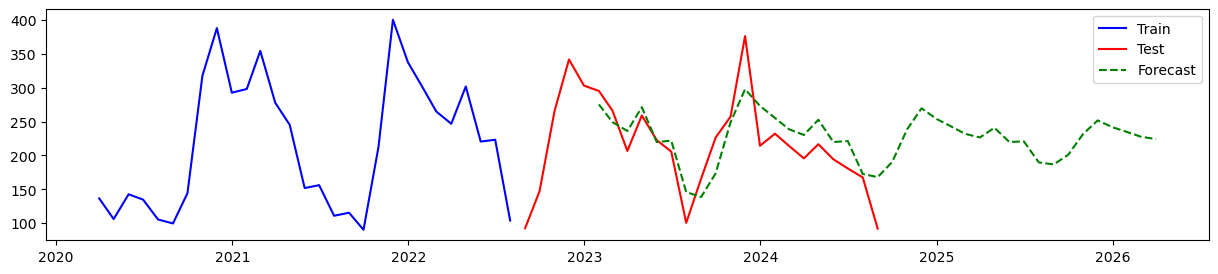

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(X_train,"b-", label='Train')
plt.plot(X_test,"r-", label='Test')
plt.plot(preds,"g--", label='Forecast')
plt.legend()

The long-term predictions generated by the model show a relatively stable pattern with some minor fluctuations. However, the model does not seem to capture sharp peaks, especially in the latter part of 2025 and early 2026, which suggests that the model may not be fully capable of predicting extreme events with high accuracy.